<a href="https://colab.research.google.com/github/olegaobini/kuiper-prep/blob/main/iq_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I/Q Sampling

There's a lot of information packed into the magnitude and phase of a received signal... how do we extract it?

In this notebook, I'll go over in-phase and quadrature (I/Q) sampling and how it allows you to extract phase information from a received signal, which is important for applications from radar to communications.

> Provided as supplemental material for [Marshall Bruner](https://tinyurl.com/marshall-bruner-yt)'s [animated video on I/Q sampling](https://youtu.be/Ev3lZClnLhQ).

- [Website (MarshallBruner.com)](https://marshallbruner.com)
- [GitHub](https://tinyurl.com/github-nb)
- [YouTube](https://tinyurl.com/marshall-bruner-yt-nb)

![thumbnail](https://drive.google.com/uc?id=1YYD-drseOl0w_qidr8KUKMSdo7b76Z0s)



In [ ]:
# If you want the fonts (takes a while)
# !apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import pi, c, mph
from numpy.fft import fft, fftshift, ifft

%matplotlib inline
plt.style.use("ggplot")
# plt.rcParams.update(
#     {
#         "text.usetex": True,
#         "font.family": "typeface",
#     }
# )  # Makes plotting slower but prettier (requires LaTeX installed)

## Why should you care?
When a radar transmits a signal and that signal echoes off a target, not only does the signal's magnitude change depending on how far it has to travel and what the target is, but the target also causes some changes to the phase of the signal.

This phase is incredibly important because it can help us determine not just that a target is there, but also *how* it’s moving including its velocity, direction, and even subtle shifts over time that raw magnitude alone can’t reveal.

Unfortunately for us, when the signal makes it back to the radar, if we just directly sample it to get it into the digital domain, we lose a lot of that phase information.

Luckily, there's another way we can get this phase information: through in-phase and quadrature sampling - otherwise known as I/Q sampling.

## Introducing: In-phase and Quadrature

An electromagnetic wave is not itself complex; we give it a complex representation to make processing simpler.

When transmitting a signal, we transmit a single sine / cosine wave,
\begin{equation}
x(t) = A(t) \cos{(2 \pi f_c t + \phi(t))}
\end{equation}
where $A(t)$ is the amplitude over time, $f_c$ is the carrier frequency (often in the GHz range), and $\phi(t)$ is the phase over time.

For a single time, $t_0$, $x(t)$ will output a single value which means it's impossible to pull out phase information from it:
$\cos{(\theta)}$ and $\cos{(-\theta)}$ give the same output, so the phase is ambiguous.

So, let's see how we can pull more information out of this received signal.

What we know:
- Basic trig functions have ambiguity of the input angle $\rightarrow$ an output value could be the result of 2 possible input angles
    - $\cos{(\theta)} = \cos{(-\theta)}$
    - $\sin{(\theta)} = \sin{(\pi-\theta)}$ or $-\sin{(\theta)} = \sin{(-\theta)}$
    - Check out the plot below $\downarrow$
- The complex exponential, $e^{j \theta t}$, is deterministic $\rightarrow$ one input angle, $0 \le \theta \le 2 \pi$, gives one unique value on the unit circle


### Example: Using only $I(t)$ or $Q(t)$ introduces ambiguity

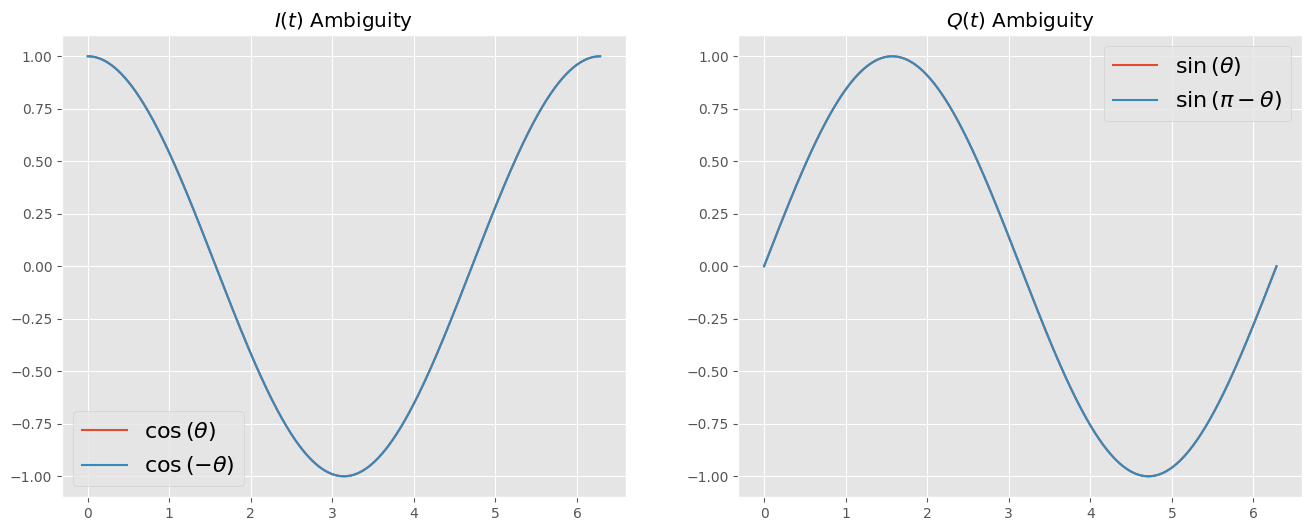

In [ ]:
t = np.linspace(0, 2 * pi, 1000)
i = np.cos(t)
i_neg = np.cos(-t)
q = np.sin(t)
q_m_pi = np.sin(pi - t)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(t, i, label=r"$\cos{(\theta)}$")
axes[0].plot(t, i_neg, label=r"$\cos{(-\theta)}$")
axes[1].plot(t, q, label=r"$\sin{(\theta)}$")
axes[1].plot(t, q_m_pi, label=r"$\sin{(\pi - \theta)}$")
axes[0].legend(fontsize=16)
axes[1].legend(fontsize=16)
axes[0].set_title(r"$I(t)$ Ambiguity")
axes[1].set_title(r"$Q(t)$ Ambiguity")
plt.show()

Let's try to get the received signal, $x(t)$, into a complex exponential so we can extract phase from it which will be useful for determining Doppler velocity, etc.

\begin{equation}
    e^{j \theta t} = \cos{(\theta t)} + j \sin{(\theta t)}
\end{equation}

First we'll multiply the received signal by a cosine and sine function

\begin{aligned}
    x(t) \cdot \cos{(2 \pi f_c t)} &= A(t) \cos{(2 \pi f_c t + \phi(t))} \cdot \cos{(2 \pi f_c t)} \\
    x(t) \cdot \sin{(2 \pi f_c t)} &= A(t) \cos{(2 \pi f_c t + \phi(t))} \cdot \sin{(2 \pi f_c t)} \\
\end{aligned}

> In real life, this would be done using a mixer which is basically just a microwave block that multiplies the 2 inputs. In our case: $x(t)$ with $\cos{(2 \pi f_c t)}$ or $\sin{(2 \pi f_c t)}$.
You can read more about them [here](https://www.digikey.com/en/articles/the-basics-of-mixers) or watch my video on the [Implementation of FMCW Radar](https://tinyurl.com/fmcw-implementation) (hopefully my explanations have gotten better since making that video, but it's still an ok resource you can reference for this).

Using some trig identities,
\begin{aligned}
    \cos{(a)}\cos{(b)} &= \frac{1}{2} \left[ \cos{(a - b)} + \cos{(a + b)} \right] \\
    \sin{(a)}\cos{(b)} &= \frac{1}{2} \left[ \sin{(a - b)} + \sin{(a + b)} \right] \\
\end{aligned}

we can see that these multiplications come out to
\begin{aligned}
    I(t) &= \frac{A(t)}{2} \left[ \cos{(\phi(t))} + \cos{(4 \pi f_c t + \phi(t))} \right] \\
    Q(t) &= \frac{A(t)}{2} \left[ \sin{(\phi(t))} + \sin{(4 \pi f_c t + \phi(t))} \right]
\end{aligned}

That's still a lot of terms... but notice how we now have a term that is solely reliant on the phase over time, $\phi(t)$, in both of these equations.

The rate of change of these sinusoids reliant on the phase, $\cos{(\phi(t))}$ and $\sin{(\phi(t))}$, will be much slower changing than the other terms,
$\cos{(4 \pi f_c t + \phi(t))}$ and $\sin{(4 \pi f_c t + \phi(t))}$, because the latter has a term relative to the carrier frequency, $f_c$ -
remember how I said the carrier frequency is often in the GHz range?!

So... couldn't we just run a low-pass filter over this and get rid of everything but the $\cos{(\phi(t))}$ and $\sin{(\phi(t))}$ terms?

Doing that, we get the final terms for $I(t)$ and $Q(t)$:
\begin{aligned}
    I(t) &= \frac{A(t)}{2} \cos{(\phi(t))} \\
    Q(t) &= \frac{A(t)}{2} \sin{(\phi(t))}
\end{aligned}

We're so close!

Our original motivation was to get the input, $x(t)$, in the form of a complex exponential, $e^{j \theta t}$, so we can extract phase reliably.

So, we could just do
\begin{aligned}
    I(t) + j Q(t) = \frac{A(t)}{2} \left[ \cos{(\phi(t))} + j \sin{(\phi(t))} \right] = \boxed{\frac{A(t)}{2} e^{j \phi(t)}}
\end{aligned}

And there you have it.
Using this complex exponential, we know the magnitude *and* phase at any given point in time, $t$.

You can see this magnitude and phase easily by plotting it in the complex plane.

> Note: The below numbers are unrealistic (no one's operating a radar at 50 Hz).
Try plugging in more realistic numbers... say for an S-band radar and a target moving at 10m/s

In [ ]:
fs = 1000  # Sampling frequency (Hz)
t = np.arange(0, 1, 1 / fs)  # time (s)
f_c = 50  # Carrier frequency (Hz)

# Time-varying phase
phi = np.sin(2 * pi * 0.5 * t)


# Real-valued RF signal
x = np.cos(2 * np.pi * f_c * t + phi)

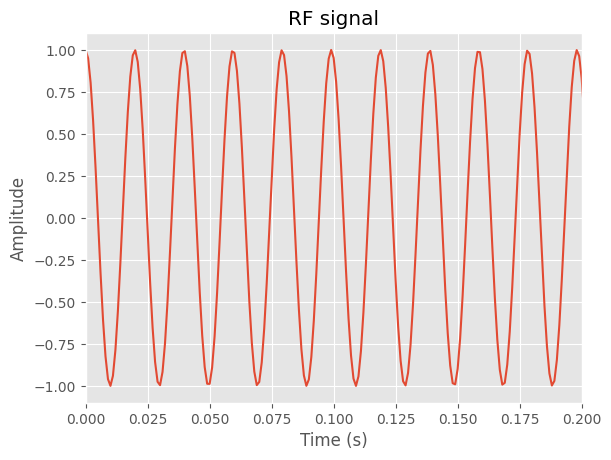

In [ ]:
plt.plot(t, x)
plt.xlim(0, 0.2)
plt.title("RF signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

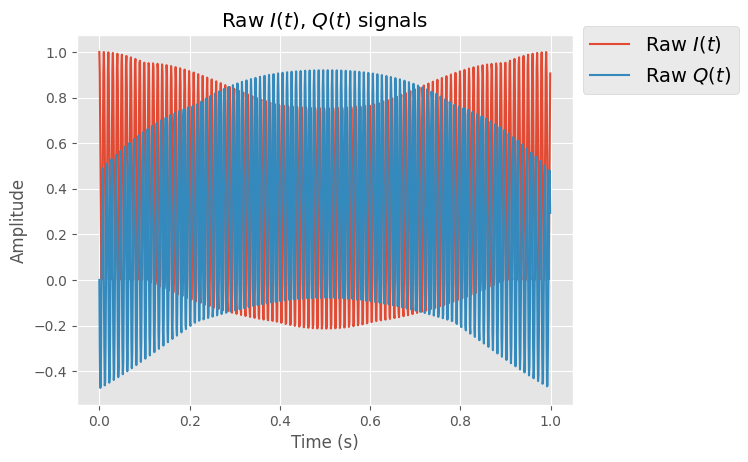

In [ ]:
I_raw = x * np.cos(2 * pi * f_c * t)
Q_raw = x * -np.sin(2 * pi * f_c * t)
plt.plot(t, I_raw, label="Raw $I(t)$")
plt.plot(t, Q_raw, label="Raw $Q(t)$")
# plt.plot(t, x, label="x")
# plt.xlim(0, 0.2)
plt.title("Raw $I(t)$, $Q(t)$ signals")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1.05), fontsize=14)
plt.show()

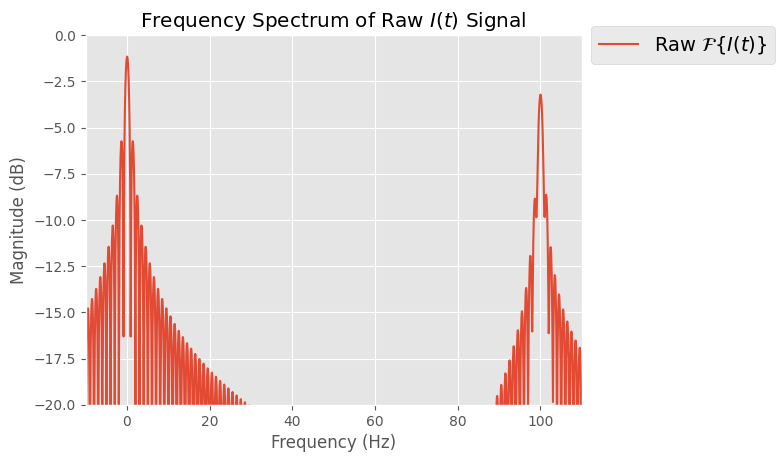

In [ ]:
fftlen = 2**14
I_fft = fft(I_raw, fftlen)
freq = np.linspace(-fs / 2, fs / 2, fftlen)
plt.plot(
    freq,
    fftshift(10 * np.log10(np.abs(I_fft) / (t.size / 2))),
    label=r"Raw $\mathcal{F}\{I(t)\}$",
)
plt.ylim(-20, 0)
plt.xlim(-10, f_c * 2.2)
plt.title("Frequency Spectrum of Raw $I(t)$ Signal")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1.05), fontsize=14)
plt.show()

> Note: $\mathcal{F}\{x\}$ is the Fourier Transform of $x$

### Filtering out the carrier frequency
We see above that the peak from the phase term, $\phi(t)$, is *much* in lower frequency than the carrier term, especially since multiplying $x(t)$ by $\cos{(2 \pi f_c t)}$ causes the carrier frequency term, $f_c$, to double.

This means that to pull out $\phi(t)$, we can just apply a low-pass filter.
A simple way to go about this in the time domain (so we don't have to convert to and from the frequency domain) is by convolving it with an array of ones.
This effectively performs a moving average over the raw $I(t)$ which removes any sharp discontinuities (i.e., high-frequency components).

> Note: The length of the filter will determine how sharp of a low-pass filter it is. Try changing the length and seeing how it affects the high-frequency rejection.

In [ ]:
filter_len = 31
window = np.ones(filter_len) / filter_len

I_filt = np.convolve(I_raw, window, mode="same")
Q_filt = np.convolve(Q_raw, window, mode="same")

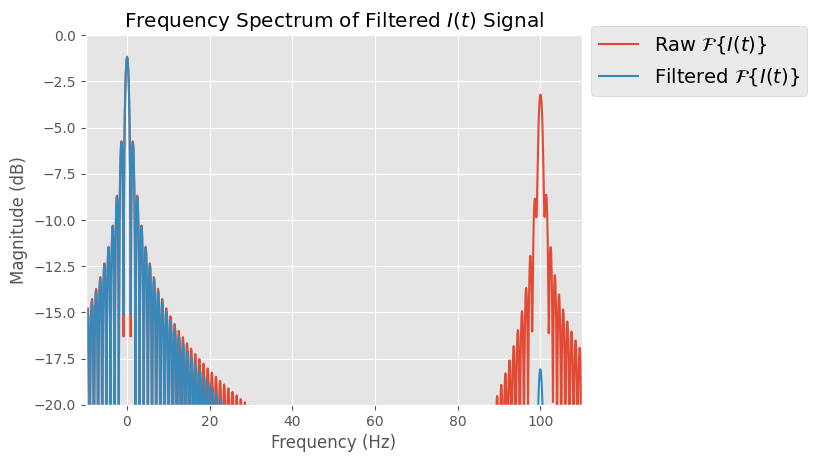

In [ ]:
I_filt_fft = fft(I_filt, fftlen)
plt.plot(
    freq,
    fftshift(10 * np.log10(np.abs(I_fft) / (t.size / 2))),
    label=r"Raw $\mathcal{F}\{I(t)\}$",
)
plt.plot(
    freq,
    fftshift(10 * np.log10(np.abs(I_filt_fft) / (t.size / 2))),
    label=r"Filtered $\mathcal{F}\{I(t)\}$",
)
plt.ylim(-20, 0)
plt.xlim(-10, f_c * 2.2)
plt.title("Frequency Spectrum of Filtered $I(t)$ Signal")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1.05), fontsize=14)
plt.show()

Now with the high-frequency component *mostly* filtered out, we can see the effect of the time-varying phase on our $I(t)$ and $Q(t)$ functions.

You still see some high-frequency components (because no filter is perfect) in the form of the line being *squiggly*, but the amplitude has been significantly dropped and shouldn't affect our measurement too much.

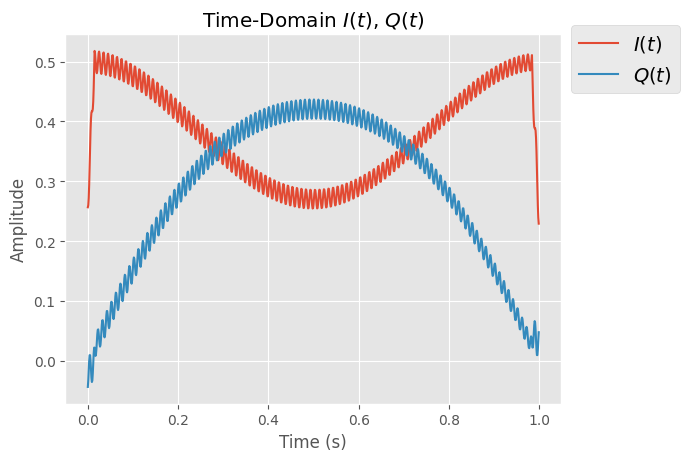

In [ ]:
plt.plot(t, I_filt, label="$I(t)$")
plt.plot(t, Q_filt, label="$Q(t)$")
plt.title("Time-Domain $I(t)$, $Q(t)$")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1.05), fontsize=14)
plt.show()

Now we can take these $I(t)$ and $Q(t)$ signals and combine them to form the complex exponential in the form of $z = e^{j \phi t} = I + jQ$.

In [ ]:
z = I_filt + 1j * Q_filt

We now have phase information stored in a complex exponential to extract using
\begin{equation}
    \phi(t) \approx \arg\{z(t)\} = \tan^{-1}{\left(\frac{\Im\{z(t)\}}{\Re\{z(t)\}}\right)}
\end{equation}
where $\Re\{z(t)\}$ and $\Im\{z(t)\}$ denote the real and imaginary parts of $z(t)$, respectively.

Plotting the computed phase, $\arg\{z(t)\}$, you can still see some of those high-frequency components, but it gives you a good approximation of the actual input phase, $\phi(t)$.

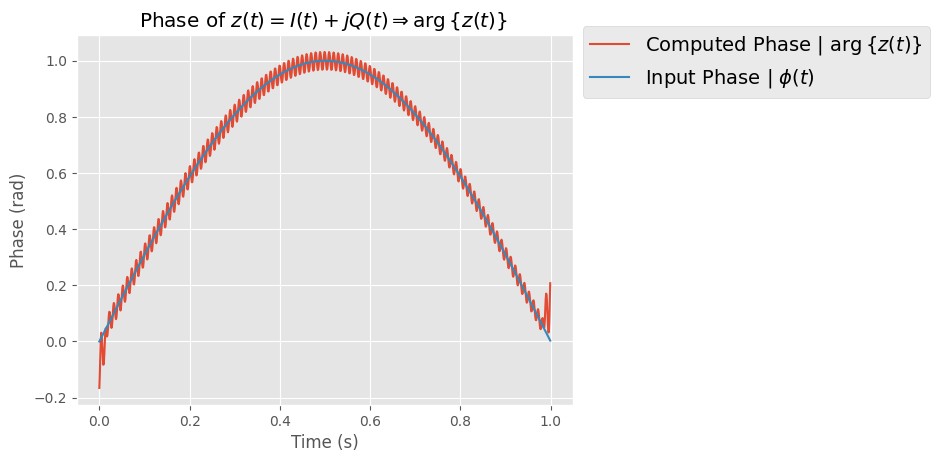

In [ ]:
phase = np.arctan(np.imag(z) / np.real(z))
plt.plot(t, phase, label=r"Computed Phase | $\arg\{z(t)\}$")
plt.plot(t, np.ones_like(t) * phi, label=r"Input Phase | $\phi(t)$")
plt.title(r"Phase of $z(t)=I(t) + jQ(t) \Rightarrow \arg\{z(t)\}$ ")
plt.xlabel("Time (s)")
plt.ylabel("Phase (rad)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1.05), fontsize=14)
plt.show()

## Testing

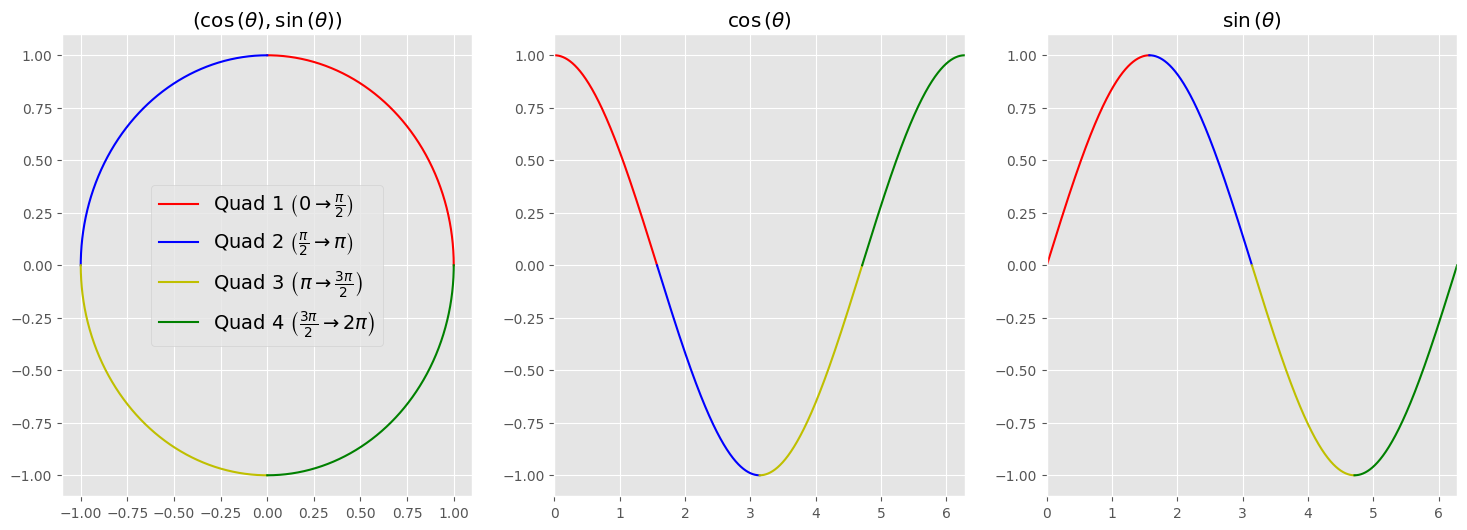

In [ ]:
f = 1
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].set_title(r"$(\cos{(\theta)}, \sin{(\theta)})$")
ax[0].set_xlim(-1.1, 1.1)
ax[0].set_ylim(-1.1, 1.1)

ax[1].set_title(r"$\cos{(\theta)}$")
ax[1].set_xlim(0, 2 * pi)
ax[1].set_ylim(-1.1, 1.1)

ax[2].set_title(r"$\sin{(\theta)}$")
ax[2].set_xlim(0, 2 * pi)
ax[2].set_ylim(-1.1, 1.1)

t = np.linspace(0, pi / 2, 1000)
cos = np.cos(f * t)
sin = np.sin(f * t)

ax[0].plot(
    cos,
    sin,
    c="r",
    label=r"Quad 1 $\left( 0 \rightarrow \frac{\pi}{2} \right)$",
)
ax[1].plot(t, cos, c="r")
ax[2].plot(t, sin, c="r")


t = np.linspace(pi / 2, pi, 1000)
cos = np.cos(f * t)
sin = np.sin(f * t)
ax[0].plot(
    cos,
    sin,
    c="b",
    label=r"Quad 2 $\left( \frac{\pi}{2} \rightarrow \pi \right)$",
)
ax[1].plot(t, cos, c="b")
ax[2].plot(t, sin, c="b")

t = np.linspace(pi, 3 * pi / 2, 1000)
cos = np.cos(f * t)
sin = np.sin(f * t)
ax[0].plot(
    cos,
    sin,
    c="y",
    label=r"Quad 3 $\left( \pi \rightarrow \frac{3 \pi}{2} \right)$",
)
ax[1].plot(t, cos, c="y")
ax[2].plot(t, sin, c="y")

t = np.linspace(3 * pi / 2, 2 * pi, 1000)
cos = np.cos(f * t)
sin = np.sin(f * t)
ax[0].plot(
    cos,
    sin,
    c="g",
    label=r"Quad 4 $\left(\frac{3 \pi}{2} \rightarrow 2 \pi \right)$",
)
ax[1].plot(t, cos, c="g")
ax[2].plot(t, sin, c="g")
ax[0].legend(fontsize=14)

plt.show()

In [ ]:
v = 10  # m/s
# v = 100 * mph  # mph
fc = 3e9  # Hz
wavelength = c / fc  # m
fd = 2 * v / wavelength  # Hz
print(f"Doppler frequency due to {v:.2f} m/s target: {fd:.2f} Hz")

Doppler frequency due to 10.00 m/s target: 200.14 Hz
